Whatever it is the kind of SP designed, as a loyalty tool, we need to focus the good performance of our SP on the following topics per customer:

+ Increase **purchasing frequency**
+ Increase **basket average**
+ Increase **retention** in the mid-long term
+ Increase **CLV**
+ Not damage the margin despite of the discount provided

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
from warnings import filterwarnings
filterwarnings('ignore')

#### Customer data extraction and processing

Let's do the connection set up to Postgres DB and check the tables we can use to support our new eligibility policy

First we will try with a toy example getting data back from only one shop: ES customers & orders

In [ ]:
# We don´t have the data corresponding to a PG Share in the basket...can get it back from Oracle if required

In [ ]:
# Need to compute somehow the purchasing frequency - quarterly? -

In [59]:
#Around half million customers
es_customers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482767 entries, 0 to 487977
Data columns (total 9 columns):
cop_c_id                   482767 non-null int64
cop_pref_o_ext_s_id        482767 non-null int64
cop_g_order_count          482767 non-null int64
cop_g_net_total            482767 non-null float64
cop_g_cm2                  482767 non-null float64
c_registration_ext_s_id    482767 non-null int64
c_registration_date        482767 non-null datetime64[ns]
basket_avg                 482767 non-null float64
cm2%                       482767 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 36.8 MB


In [10]:
# Number of orders grouped by preferred site of the customer
es_customers.groupby('cop_pref_o_ext_s_id')['cop_g_order_count'].sum().sort_values(ascending=False)

cop_pref_o_ext_s_id
15    1547982
28       7782
1        4181
4        2643
3        2484
12       1843
7         810
2         621
25        434
14        309
11        304
8         270
26        262
21        162
18         73
24         55
22         54
31         50
19         47
16         42
30         41
20         11
29          6
23          1
Name: cop_g_order_count, dtype: int64

In [11]:
# Let's get for the calculations all ES customers whose preferred site is also ES Shop
es_customers = es_customers[es_customers['cop_pref_o_ext_s_id'] == 15]

In [54]:
#es_customers.to_csv('es_cust_reg_pref.csv', sep=';', index=False, encoding='utf-8')

#### Customer data

In [2]:
es_customers = pd.read_csv('es_cust_reg_pref.csv', sep=';')

In [3]:
es_customers['c_registration_date'] = pd.to_datetime(es_customers['c_registration_date'], format='%Y-%m-%d')

In [4]:
# Get CM2% per customer
es_customers['cm2%'] = es_customers['cop_g_cm2'] / es_customers['cop_g_net_total'] * 100

In [5]:
es_customers['cm2%'] = es_customers['cm2%'].replace(-np.inf, 0)

In [6]:
es_customers[es_customers['cm2%'] == es_customers['cm2%'].min()]

,cop_c_id,cop_pref_o_ext_s_id,cop_g_order_count,cop_g_net_total,cop_g_cm2,c_registration_ext_s_id,c_registration_date,cm2%
37817,19725836,15,4,0.063636,-109.237586,15,2018-03-17,-171660.044629


In [7]:
es_customers = es_customers.drop(es_customers.index[37817])

In [8]:
# And basket average
es_customers['net_basket_avg'] = es_customers['cop_g_net_total'] / es_customers['cop_g_order_count']

In [9]:
es_customers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482766 entries, 0 to 482766
Data columns (total 9 columns):
cop_c_id                   482766 non-null int64
cop_pref_o_ext_s_id        482766 non-null int64
cop_g_order_count          482766 non-null int64
cop_g_net_total            482766 non-null float64
cop_g_cm2                  482766 non-null float64
c_registration_ext_s_id    482766 non-null int64
c_registration_date        482766 non-null datetime64[ns]
cm2%                       482766 non-null float64
net_basket_avg             482766 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 36.8 MB


In [10]:
es_customers[es_customers['c_registration_date'] == es_customers['c_registration_date'].min()]

,cop_c_id,cop_pref_o_ext_s_id,cop_g_order_count,cop_g_net_total,cop_g_cm2,c_registration_ext_s_id,c_registration_date,cm2%,net_basket_avg
405981,1496305,15,1,36.924793,2.21111,15,2008-04-15,5.988145,36.924793


In [11]:
es_customers.groupby(es_customers['c_registration_date'].dt.year)['cop_c_id'].count()

c_registration_date
2008      1978
2009      6516
2010     13503
2011     17690
2012     22673
2013     26461
2014     35507
2015     61304
2016    102984
2017    117498
2018     76652
Name: cop_c_id, dtype: int64

In [12]:
es_customers = es_customers[es_customers['c_registration_date'].dt.year >= 2015]

In [13]:
es_customers.groupby(es_customers['c_registration_date'].dt.year)['cop_c_id'].count()

c_registration_date
2015     61304
2016    102984
2017    117498
2018     76652
Name: cop_c_id, dtype: int64

In [14]:
es_customers['net_basket_avg'].describe()

count    358438.000000
mean         52.782606
std          31.354045
min           0.000000
25%          35.990909
50%          46.179957
75%          61.809091
max        2625.311157
Name: net_basket_avg, dtype: float64

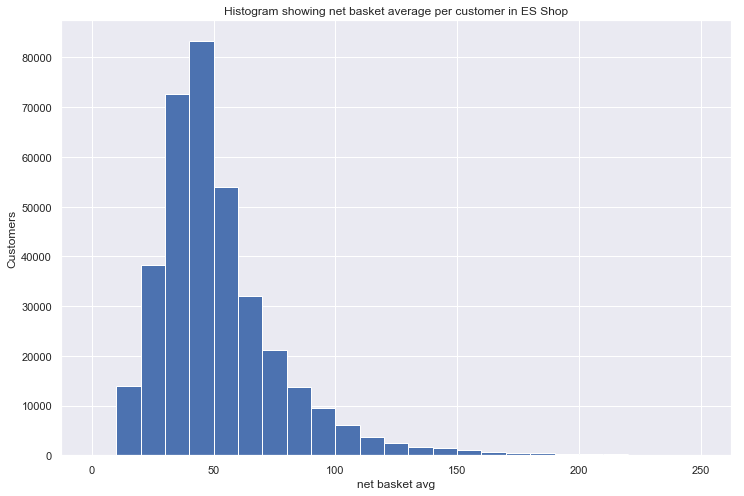

In [15]:
# Each bin has a width of 10€
sns.set()
plt.figure(figsize=(12, 8))
es_customers['net_basket_avg'].hist(bins=25, range=(0, 250))
plt.grid(True)
plt.title('Histogram showing net basket average per customer in ES Shop')
plt.xlabel('net basket avg')
plt.ylabel('Customers')
plt.show()

In [16]:
es_customers['cm2%'].describe()

count    358438.000000
mean         10.683292
std          15.097932
min       -4336.175889
25%           3.860450
50%          10.797188
75%          17.997210
max         100.000000
Name: cm2%, dtype: float64

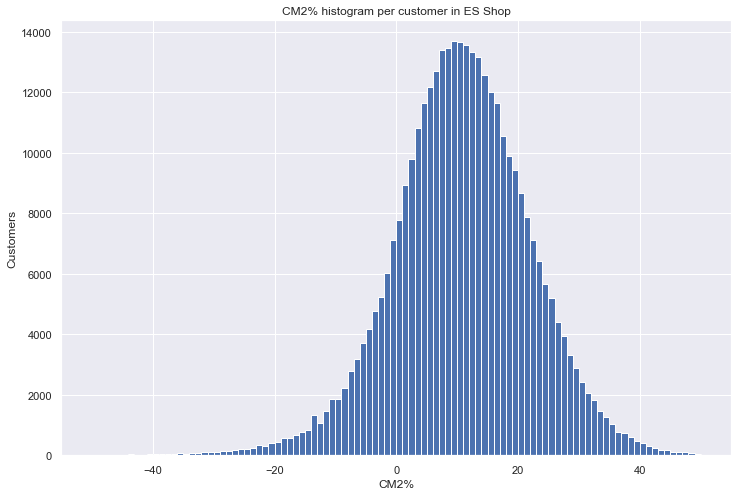

In [17]:
# Each bin has a width of 1% in terms of CM2%
sns.set()
plt.figure(figsize=(12, 8))
es_customers['cm2%'].hist(bins=100, range=(-50, 50))
plt.grid(True)
plt.title('CM2% histogram per customer in ES Shop')
plt.xlabel('CM2%')
plt.ylabel('Customers')
plt.show()

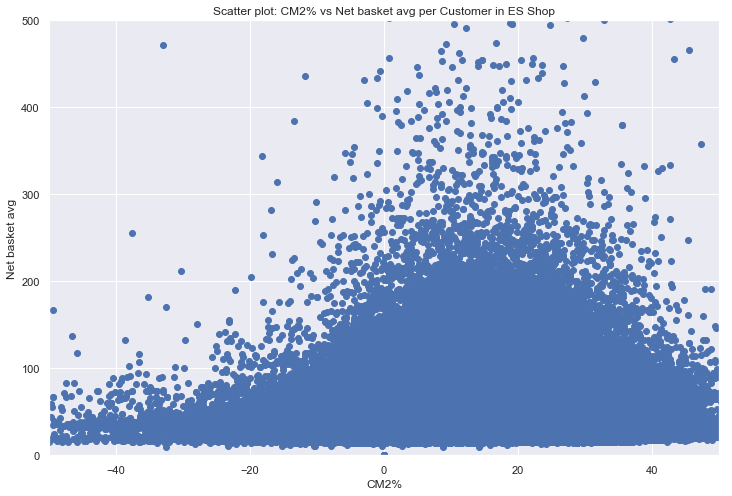

In [18]:
sns.set()
plt.figure(figsize=(12, 8))
plt.scatter(es_customers['cm2%'], es_customers['net_basket_avg'])
plt.xlim(-50, 50)
plt.ylim(0, 500)
plt.grid(True)
plt.title('Scatter plot: CM2% vs Net basket avg per Customer in ES Shop')
plt.xlabel('CM2%')
plt.ylabel('Net basket avg')
plt.show()

In [19]:
np.corrcoef(es_customers['cm2%'], es_customers['net_basket_avg'])

array([[1.        , 0.06814384],
       [0.06814384, 1.        ]])

#### Orders data extraction and processing

Now, from the selected customers we want to collect their orders data (id, date, net_sales, cm2, lead_pg3, lead_pg4...)

In [13]:
# 1st approach generating a string from the list of customers and passing it through the IN clause

In [15]:
# 2nd approach: use cursor and chunksize from pd.read_sql

In [14]:
# 3rd approach: join on customer ID with the previous table

In [ ]:
#4th approximation: get orders placed in ES Shop

In [40]:
query = """SELECT o.o_id, o.o_c_id, o.o_ext_s_id, o.o_date, o.o_delivery_ext_c_id,
ocm.ocm_net_total, ocm.ocm_cm2,
olpg.olpg_l3_ext_pg_id, olpg.olpg_l4_ext_pg_id
FROM public.orders o
JOIN public.order_lead_pgs olpg
ON o.o_id = olpg.olpg_o_id
JOIN public.order_contribution_margins ocm
ON o.o_id = ocm.ocm_o_id
where o.o_ext_s_id = 15
and date_trunc('day', o.o_date) < date_trunc('day', current_timestamp)
"""

In [42]:
conn = psycopg2.connect("dbname='savings_plan_db' user='dba' host='savings-plan-prod-c-savings-plan-db-readonly.ccsod6gcmvcs.eu-central-1.rds.amazonaws.com' password='m4d_l0y_db4?'")
es_orders = pd.read_sql(query, con = conn)
conn.close()

In [43]:
es_orders.head().round(2)

,o_id,o_c_id,o_ext_s_id,o_date,o_delivery_ext_c_id,ocm_net_total,ocm_cm2,olpg_l3_ext_pg_id,olpg_l4_ext_pg_id
0,113316547,12270625,15,2018-06-22,48,60.70,11.21,252,95904
1,113323236,9912290,15,2018-06-22,49,49.25,8.15,251,118221
2,113876028,14115278,15,2018-07-01,49,107.95,16.82,251,31962
3,113342462,6737523,15,2018-06-23,49,62.71,1.81,252,683
4,113346916,19415739,15,2018-06-23,49,57.26,1.66,251,81396


In [45]:
es_orders.to_csv('es_shop_orders_from_postgres.csv', sep=';', index=False, encoding='utf-8')

#### Orders data

In [20]:
es_orders = pd.read_csv('es_shop_orders_from_postgres.csv', sep=';', low_memory=False)

In [21]:
es_orders['o_date'] = pd.to_datetime(es_orders['o_date'], format='%Y-%m-%d')

In [22]:
es_orders['o_cm2%'] = es_orders['ocm_cm2'] / es_orders['ocm_net_total'] * 100

In [23]:
es_orders['o_cm2%'] = es_orders['o_cm2%'].replace(-np.inf, 0)

In [24]:
es_orders['o_cm2%'].describe().round(2)

count    2785074.00
mean          10.16
std           86.93
min      -110500.27
25%            3.28
50%           10.79
75%           18.18
max          100.00
Name: o_cm2%, dtype: float64

In [25]:
es_orders[es_orders['o_cm2%'] == es_orders['o_cm2%'].min()]

,o_id,o_c_id,o_ext_s_id,o_date,o_delivery_ext_c_id,ocm_net_total,ocm_cm2,olpg_l3_ext_pg_id,olpg_l4_ext_pg_id,o_cm2%
2770001,76683750,5706005,15,2016-10-29,15,0.036364,-40.18232,252,15418,-110500.274997


In [26]:
es_orders = es_orders.drop(es_orders.index[2770001])

In [27]:
es_orders.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2785073 entries, 0 to 2785073
Data columns (total 10 columns):
o_id                   int64
o_c_id                 int64
o_ext_s_id             int64
o_date                 datetime64[ns]
o_delivery_ext_c_id    int64
ocm_net_total          float64
ocm_cm2                float64
olpg_l3_ext_pg_id      int64
olpg_l4_ext_pg_id      int64
o_cm2%                 float64
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 233.7 MB


In [28]:
es_orders['o_cm2%'].describe().round(2)

count    2785073.00
mean          10.20
std           56.32
min       -41269.89
25%            3.28
50%           10.79
75%           18.18
max          100.00
Name: o_cm2%, dtype: float64

In [29]:
es_customers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358438 entries, 0 to 482766
Data columns (total 9 columns):
cop_c_id                   358438 non-null int64
cop_pref_o_ext_s_id        358438 non-null int64
cop_g_order_count          358438 non-null int64
cop_g_net_total            358438 non-null float64
cop_g_cm2                  358438 non-null float64
c_registration_ext_s_id    358438 non-null int64
c_registration_date        358438 non-null datetime64[ns]
cm2%                       358438 non-null float64
net_basket_avg             358438 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 37.3 MB


In [30]:
es_orders['o_date'].min()

Timestamp('2011-07-21 00:00:00')

In [31]:
es_orders.groupby(es_orders['o_date'].dt.year)['o_id'].count()

o_date
2011     41844
2012     23288
2015    296827
2016    717938
2017    936172
2018    769004
Name: o_id, dtype: int64

In [32]:
es_orders = es_orders[es_orders['o_date'].dt.year >= 2015]

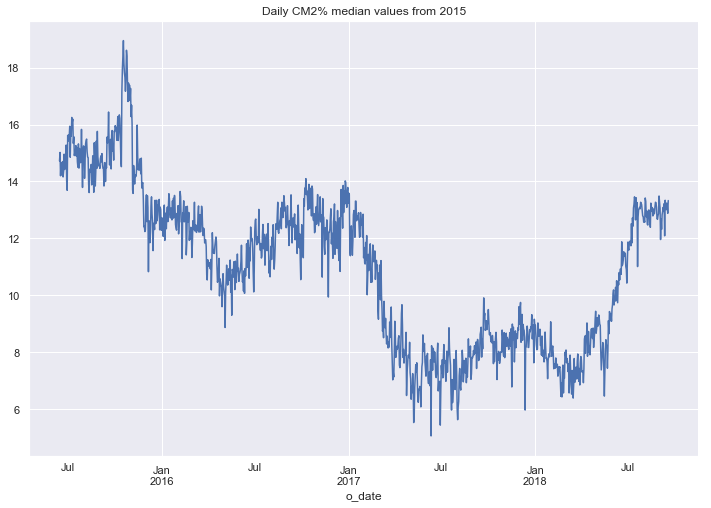

In [33]:
# Daily CM2% median values from 2015
sns.set()
plt.figure(figsize=(12, 8))
es_orders.groupby('o_date')['o_cm2%'].median().round(2).plot()
plt.title('Daily CM2% median values from 2015')
plt.show()

#### Joining data 

In [34]:
df_es = es_orders.merge(es_customers, how='inner', left_on='o_c_id', right_on='cop_c_id')

In [35]:
df_es.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1537592 entries, 0 to 1537591
Data columns (total 19 columns):
o_id                       1537592 non-null int64
o_c_id                     1537592 non-null int64
o_ext_s_id                 1537592 non-null int64
o_date                     1537592 non-null datetime64[ns]
o_delivery_ext_c_id        1537592 non-null int64
ocm_net_total              1537592 non-null float64
ocm_cm2                    1537592 non-null float64
olpg_l3_ext_pg_id          1537592 non-null int64
olpg_l4_ext_pg_id          1537592 non-null int64
o_cm2%                     1537592 non-null float64
cop_c_id                   1537592 non-null int64
cop_pref_o_ext_s_id        1537592 non-null int64
cop_g_order_count          1537592 non-null int64
cop_g_net_total            1537592 non-null float64
cop_g_cm2                  1537592 non-null float64
c_registration_ext_s_id    1537592 non-null int64
c_registration_date        1537592 non-null datetime64[ns]
cm2%     

In [36]:
df_es.sample(5).round(2)

,o_id,o_c_id,o_ext_s_id,o_date,o_delivery_ext_c_id,ocm_net_total,ocm_cm2,olpg_l3_ext_pg_id,olpg_l4_ext_pg_id,o_cm2%,cop_c_id,cop_pref_o_ext_s_id,cop_g_order_count,cop_g_net_total,cop_g_cm2,c_registration_ext_s_id,c_registration_date,cm2%,net_basket_avg
1085178,89263885,11151094,15,2017-06-19,49,41.72,7.76,252,31963,18.60,11151094,15,3,115.72,25.22,15,2015-02-22,21.79,38.57
1118392,92334331,12111091,15,2017-08-10,49,52.96,2.11,252,683,3.99,12111091,15,15,704.96,28.46,15,2015-07-31,4.04,47.00
1508329,108943689,20000487,15,2018-04-17,49,23.92,8.55,2155,2156,35.73,20000487,15,1,23.92,8.55,15,2018-04-17,35.73,23.92
268458,97594847,18406294,15,2017-11-02,49,33.39,7.65,252,3641,22.92,18406294,15,2,89.07,14.43,15,2017-11-02,16.20,44.54
1533987,87786953,16910713,15,2017-05-23,49,16.63,1.69,23,50014,10.18,16910713,15,1,16.63,1.69,15,2017-05-23,10.18,16.63


In [37]:
df_es['o_c_id'].nunique()

358415

In [38]:
# Customers registered in the last year
df_es[df_es['c_registration_date'] > '2017-09-19']['o_c_id'].nunique()

110528

In [39]:
# Customers registered in the last 2 years
df_es[df_es['c_registration_date'] > '2016-09-19']['o_c_id'].nunique()

225008

In [40]:
# Customers registered in the last 3 years
df_es[df_es['c_registration_date'] > '2015-09-19']['o_c_id'].nunique()

321552

#### Build customer dict: purchasing period, n orders, net_sales, main PG4 (% sales y % orders)

In [41]:
cus_dict_pg4 = {}

for i in df_es['o_c_id'].unique():
    cus_data = df_es[df_es['o_c_id'] == i]
    pg4_list = list(cus_data.sort_values(by='o_date')['olpg_l4_ext_pg_id'].values)
    cus_dict_pg4[i] = pg4_list

In [42]:
cus_dict_net_sales = {}

for i in df_es['o_c_id'].unique():
    cus_data = df_es[df_es['o_c_id'] == i]
    net_sales_list = list(cus_data.sort_values(by='o_date')['ocm_net_total'].round(2).values)
    cus_dict_net_sales[i] = net_sales_list

In [43]:
cus_dict_order_dates = {}
cus_dict_order_timedeltas = {}

for i in df_es['o_c_id'].unique():
    cus_data = df_es[df_es['o_c_id'] == i]
    order_dates_list = list(cus_data.sort_values(by='o_date')['o_date'].values)
    order_timedeltas_days = (cus_data.sort_values(by='o_date')['o_date'].shift(-1) - cus_data.sort_values(by='o_date')['o_date'])
    order_timedeltas_list = list(order_timedeltas_days.apply(lambda x:x.days)[:-1].astype(int).values)
    cus_dict_order_dates[i] = order_dates_list
    cus_dict_order_timedeltas[i] = order_timedeltas_list

In [44]:
cus_dict_info = {}

for i in df_es['o_c_id'].unique():
    
    cus_dict_info[i] = {}
    cus_dict_info[i]['c_id'] = i
    
    #cus_dict_info[i]['orders_lead_pg4'] = cus_dict_pg4[i] # for the future do it at an order position level
    cus_dict_info[i]['total_net_sales'] = sum(cus_dict_net_sales[i]) # sum values in the customer sales list from the dictionary
    cus_dict_info[i]['orders'] = len(cus_dict_net_sales[i]) # get the length of the list, one position per order
    cus_dict_info[i]['orders_info'] = [(x, y) for x, y in zip(cus_dict_pg4[i], cus_dict_net_sales[i])] # sorted tuple (lead PG4, sales) 
    cus_dict_info[i]['basket_net_avg'] = np.round(sum(cus_dict_net_sales[i]) / len(cus_dict_net_sales[i]), 2)
    if len(cus_dict_net_sales[i]) > 1:
        cus_dict_info[i]['basket_net_std'] = np.round(stdev(cus_dict_net_sales[i]), 2)
    else:
        cus_dict_info[i]['basket_net_std'] = 0
    c = Counter(cus_dict_pg4[i])
    ord_per_pg4 = sorted(c.most_common() , key= lambda x: x[0], reverse=True)
    net_sales_per_pg4 = sorted([(pg4_,sum([net_sales_ for pg_, net_sales_ in cus_dict_info[i]['orders_info'] if pg_== pg4_])) 
                                         for pg4_ in set([pg4 for pg4, net_sales in cus_dict_info[i]['orders_info']])], key= lambda x: x[0], reverse=True)
    cus_dict_info[i]['pg4_ord_net_sales'] = sorted([(x[0], x[1], y[1]) for x, y in zip(ord_per_pg4, net_sales_per_pg4)], key= lambda x: (x[1], x[2]), reverse=True)
    cus_dict_info[i]['main_pg4'] = cus_dict_info[i]['pg4_ord_net_sales'][0][0]
    cus_dict_info[i]['main_pg4_%_ord'] = np.round(cus_dict_info[i]['pg4_ord_net_sales'][0][1] / cus_dict_info[i]['orders'], 2)
    cus_dict_info[i]['main_pg4_%_net_sales'] = np.round(cus_dict_info[i]['pg4_ord_net_sales'][0][2] / cus_dict_info[i]['total_net_sales'], 2)
    cus_dict_info[i]['orders_timedeltas'] = cus_dict_order_timedeltas[i]

C:\Users\albertoma\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: invalid value encountered in double_scalars


In [45]:
cus_dict_info[12485124]

{'basket_net_avg': 62.46,
 'basket_net_std': 29.46,
 'c_id': 12485124,
 'main_pg4': 683,
 'main_pg4_%_net_sales': 0.72,
 'main_pg4_%_ord': 0.71,
 'orders': 14,
 'orders_info': [(683, 110.92),
  (683, 40.8),
  (683, 40.72),
  (683, 43.2),
  (17963, 49.23),
  (683, 60.89),
  (683, 70.04),
  (17963, 24.68),
  (683, 39.67),
  (683, 69.64),
  (683, 39.07),
  (683, 114.56),
  (17963, 108.55),
  (3155, 62.54)],
 'orders_timedeltas': [48, 42, 51, 33, 50, 69, 55, 44, 70, 62, 70, 35, 78],
 'pg4_ord_net_sales': [(683, 10, 629.51),
  (17963, 3, 182.45999999999998),
  (3155, 1, 62.54)],
 'total_net_sales': 874.51}

In [150]:
#with open('cus_dict_info.p', 'wb') as fp:
#    pickle.dump(cus_dict_info, fp, protocol=pickle.HIGHEST_PROTOCOL)

#### Load data from JSON saved with pickle: Customer info dictionary

In [2]:
with open('cus_dict_info.p', 'rb') as fp:
    cus_dict_info = pickle.load(fp)

In [4]:
type(cus_dict_info)

dict

In [3]:
cus_dict_info[list(cus_dict_info.keys())[5]]

{'basket_net_avg': 91.08,
 'basket_net_std': 39.41,
 'c_id': 11282336,
 'main_pg4': 31963,
 'main_pg4_%_net_sales': 0.9,
 'main_pg4_%_ord': 0.78,
 'orders': 18,
 'orders_info': [(31963, 83.9),
  (31963, 56.13),
  (31963, 78.5),
  (31963, 84.3),
  (31963, 95.85),
  (304, 33.05),
  (31963, 149.22),
  (31963, 50.08),
  (1070, 58.54),
  (1070, 21.98),
  (31963, 93.26),
  (31963, 149.01),
  (31963, 119.63),
  (31963, 129.99),
  (31963, 126.61),
  (31963, 121.12),
  (31963, 131.33),
  (71977, 56.97)],
 'orders_timedeltas': [83,
  69,
  68,
  91,
  4,
  91,
  44,
  32,
  24,
  7,
  65,
  88,
  109,
  119,
  86,
  111,
  73],
 'pg4_ord_net_sales': [(31963, 14, 1468.9299999999998),
  (1070, 2, 80.52),
  (71977, 1, 56.97),
  (304, 1, 33.05)],
 'total_net_sales': 1639.4699999999996}

#### New DataFrame as decision support data model (1st iteration)

In [46]:
#Pandas DataFrame
cus_attr = pd.DataFrame.from_dict(cus_dict_info, orient='index').round(2)

In [47]:
pg4_ord_cus_sets = [[(j[0], j[1]) for j in i] for i in cus_attr['pg4_ord_net_sales']]

In [48]:
#In last column we have a list of tuples showing (Lead PG4, orders)
cus_attr['pg4_ord_set'] = pg4_ord_cus_sets

In [49]:
cus_attr.sample(5)

,c_id,total_net_sales,orders,orders_info,basket_net_avg,basket_net_std,pg4_ord_net_sales,main_pg4,main_pg4_%_ord,main_pg4_%_net_sales,orders_timedeltas,pg4_ord_set
13925787,13925787,56.83,2,"[(45231, 31.31), (171638, 25.52)]",28.42,4.09,"[(45231, 1, 31.31), (171638, 1, 25.52)]",45231,0.5,0.55,[354],"[(45231, 1), (171638, 1)]"
13293858,13293858,71.04,2,"[(10331, 34.69), (683, 36.35)]",35.52,1.17,"[(683, 1, 36.35), (10331, 1, 34.69)]",683,0.5,0.51,[709],"[(683, 1), (10331, 1)]"
19913251,19913251,52.06,1,"[(10618, 52.06)]",52.06,0.00,"[(10618, 1, 52.06)]",10618,1.0,1.00,[],"[(10618, 1)]"
15034809,15034809,27.80,1,"[(2044, 27.8)]",27.80,0.00,"[(2044, 1, 27.8)]",2044,1.0,1.00,[],"[(2044, 1)]"
11351575,11351575,109.08,2,"[(201878, 46.21), (2061, 62.87)]",54.54,11.78,"[(2061, 1, 62.87), (201878, 1, 46.21)]",2061,0.5,0.58,[332],"[(2061, 1), (201878, 1)]"


In [50]:
#cus_attr.to_csv('df_customer_data_model.csv', sep=';', index=False, encoding='utf-8')

In [152]:
#cus_attr.to_pickle("./cus_attr_data_model.pkl")

#### Load DataFrame using pd.read_pickle and use order cohorts following Fibonacci numbers

In [3]:
cus_attr = pd.read_pickle("./cus_attr_data_model.pkl")

In [3]:
cus_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358415 entries, 10795342 to 21301728
Data columns (total 12 columns):
c_id                    358415 non-null int64
total_net_sales         358415 non-null float64
orders                  358415 non-null int64
orders_info             358415 non-null object
basket_net_avg          358415 non-null float64
basket_net_std          358415 non-null float64
pg4_ord_net_sales       358415 non-null object
main_pg4                358415 non-null int64
main_pg4_%_ord          358415 non-null float64
main_pg4_%_net_sales    358401 non-null float64
orders_timedeltas       358415 non-null object
pg4_ord_set             358415 non-null object
dtypes: float64(5), int64(3), object(4)
memory usage: 35.5+ MB


In [4]:
type(cus_attr['pg4_ord_set'].iloc[0]), type(cus_attr['pg4_ord_set'].iloc[0][0])

(list, tuple)

In [5]:
cus_attr.sample(5)

,c_id,total_net_sales,orders,orders_info,basket_net_avg,basket_net_std,pg4_ord_net_sales,main_pg4,main_pg4_%_ord,main_pg4_%_net_sales,orders_timedeltas,pg4_ord_set
15314208,15314208,2523.11,36,"[(17798, 85.45), (17798, 75.26), (17798, 83.63...",70.09,26.83,"[(682, 21, 1658.07), (17798, 8, 468.3800000000...",682,0.58,0.66,"[55, 22, 28, 15, 13, 29, 8, 6, 16, 15, 18, 7, ...","[(682, 21), (17798, 8), (283, 2), (683, 2), (1..."
19684321,19684321,22.44,1,"[(303098, 22.44)]",22.44,0.00,"[(303098, 1, 22.44)]",303098,1.00,1.00,[],"[(303098, 1)]"
15554325,15554325,215.52,2,"[(682, 44.54), (682, 170.98)]",107.76,89.41,"[(682, 2, 215.51999999999998)]",682,1.00,1.00,[34],"[(682, 2)]"
16468578,16468578,948.86,12,"[(31963, 86.81), (31963, 90.79), (10331, 46.92...",79.07,27.21,"[(31963, 8, 576.44), (71977, 3, 325.5), (10331...",31963,0.67,0.61,"[75, 68, 41, 60, 48, 54, 54, 24, 39, 33, 39]","[(31963, 8), (71977, 3), (10331, 1)]"
15487362,15487362,33.74,1,"[(45231, 33.74)]",33.74,0.00,"[(45231, 1, 33.74)]",45231,1.00,1.00,[],"[(45231, 1)]"


In [8]:
#Let's see how are distributed per Lead PG4 those customers having main_pg4 importance greater than 0.5
cus_attr[cus_attr['main_pg4_%_ord'] >= 0.50]['main_pg4'].value_counts().head(30)
# 207617: Spot-on

682       23129
683       17786
17798     13063
31962     10367
81396     10100
35825      7894
207615     6949
71709      6592
255        6553
31963      5757
719        5396
81397      5235
18245      5092
2060       4234
55408      3837
71977      3703
30936      3584
2216       3455
261925     3339
394        3313
283        3217
754        3058
128993     2955
92         2912
207617     2779
851        2766
71918      2745
10618      2727
720        2475
81431      2282
Name: main_pg4, dtype: int64

In [29]:
main_pg_4_es = list(cus_attr[cus_attr['main_pg4_%_ord'] >= 0.50]['main_pg4'].value_counts().head(30).index.values)

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
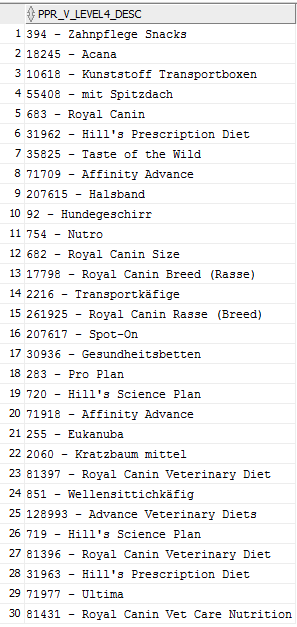

#### Main PG4 per customer in order cohorts

Let's use Fibonacci numbers for establishing order cohorts:

In [10]:
cus_attr_1 = cus_attr[cus_attr['orders'] == 1]
cus_attr_2 = cus_attr[cus_attr['orders'] == 2]
cus_attr_3 = cus_attr[cus_attr['orders'] == 3]
cus_attr_45 = cus_attr[cus_attr['orders'].between(4, 5)]
cus_attr_68 = cus_attr[cus_attr['orders'].between(6, 8)]
cus_attr_913 = cus_attr[cus_attr['orders'].between(9, 13)]
cus_attr_1421 = cus_attr[cus_attr['orders'].between(14, 21)]

And let's now see how Lead_PG4 with a relevance greater than 50% -named as main pg4 for the customer - are distributed within the customers in ES Shop: 

In [14]:
#Let's see how are distributed per Lead PG4 those customers having main_pg4 importance greater than 0.5
cus_attr_1[cus_attr_1['main_pg4_%_ord'] >= 0.50]['main_pg4'].value_counts().head(10)
# 207615: halsband
# 2060: kratzbaum mittel
# 55408: mit spitzdach
# 30936: Gesundheitsbetten
# 2216: Transportkafige
# 31962: Hill's prescription diet
# Rest of PG4: Royal Canin (Size, Rasse, Breed, Vet Diet...)

682       7166
207615    5224
683       4785
17798     3932
81396     3426
2060      3250
55408     3242
31962     2897
30936     2667
2216      2666
Name: main_pg4, dtype: int64

In [15]:
#Let's see how are distributed per Lead PG4 those customers having main_pg4 importance greater than 0.5
cus_attr_2[cus_attr_2['main_pg4_%_ord'] >= 0.50]['main_pg4'].value_counts().head(10)

682       3761
683       2722
17798     2114
81396     1741
31962     1729
35825     1334
207615    1212
18245     1115
71709     1085
255       1040
Name: main_pg4, dtype: int64

In [17]:
#Let's see how are distributed per Lead PG4 those customers having main_pg4 importance greater than 0.5
cus_attr_3[cus_attr_3['main_pg4_%_ord'] >= 0.50]['main_pg4'].value_counts().head(10)

682      2315
683      1617
17798    1214
81396     990
31962     945
35825     697
255       633
71709     624
31963     580
719       490
Name: main_pg4, dtype: int64

In [18]:
#Let's see how are distributed per Lead PG4 those customers having main_pg4 importance greater than 0.5
cus_attr_45[cus_attr_45['main_pg4_%_ord'] >= 0.50]['main_pg4'].value_counts().head(10)

682      3367
683      2637
17798    1794
31962    1419
81396    1333
35825    1076
255       924
71709     922
31963     868
719       781
Name: main_pg4, dtype: int64

In [19]:
#Let's see how are distributed per Lead PG4 those customers having main_pg4 importance greater than 0.5
cus_attr_68[cus_attr_68['main_pg4_%_ord'] >= 0.50]['main_pg4'].value_counts().head(10)

682      2883
683      2490
17798    1666
31962    1264
81396    1108
35825     859
71709     801
255       758
31963     748
719       698
Name: main_pg4, dtype: int64

In [21]:
#Let's see how are distributed per Lead PG4 those customers having main_pg4 importance greater than 0.5
cus_attr_913[cus_attr_913['main_pg4_%_ord'] >= 0.50]['main_pg4'].value_counts().head(10)

682      2148
683      2101
17798    1352
31962    1131
81396     919
35825     750
255       681
31963     627
71709     602
719       585
Name: main_pg4, dtype: int64

In [22]:
#Let's see how are distributed per Lead PG4 those customers having main_pg4 importance greater than 0.5
cus_attr_1421[cus_attr_1421['main_pg4_%_ord'] >= 0.50]['main_pg4'].value_counts().head(10)

682      1092
683      1079
17798     753
31962     736
81396     455
35825     452
719       381
255       374
71709     332
31963     292
Name: main_pg4, dtype: int64

#### Jaccard similarity calculation between customers using as set of data the Lead PG4 of every order 
[Lead_PG4_1st_order, Lead_PG4_2nd_order, Lead_PG4_N_order...]

In [53]:
from numba import jit, autojit # Numba, just-in-time compiler to speed up python code. 

In [54]:
@autojit
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return np.round(len(s1.intersection(s2)) / len(s1.union(s2)), 3)

In [55]:
#To avoid doing too much iterations let's cluster customers in groups regarding the number of orders made
cus_attr.orders.describe()

count    358415.000000
mean          4.289977
std           5.839039
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         427.000000
Name: orders, dtype: float64

In [104]:
cus_attr.orders.value_counts().head(15)

1     152327
2      53983
3      30432
4      21423
5      16482
6      13007
7      10615
8       8742
9       7486
10      6347
11      5333
12      4482
13      3854
14      3314
15      2786
Name: orders, dtype: int64

In [92]:
cus_dict_d = {key: value for key, value in list(zip(cus_attr['c_id'], cus_attr['pg4_ord_set']))}

In [101]:
dict_jacc_sim = {}

In [102]:
for i in cus_attr_1421['c_id']:
    dict_jacc_sim[i] = [(j, jaccard_similarity(cus_dict_d[i], cus_dict_d[j])) for j in cus_attr_1421['c_id']
                       if jaccard_similarity(cus_dict_d[i], cus_dict_d[j]) > 0.5 and i != j]

In [103]:
for i in cus_attr_913['c_id']:
    dict_jacc_sim[i] = [(j, jaccard_similarity(cus_dict_d[i], cus_dict_d[j])) for j in cus_attr_913['c_id']
                       if jaccard_similarity(cus_dict_d[i], cus_dict_d[j]) > 0.5 and i != j]

In [105]:
for i in cus_attr_68['c_id']:
    dict_jacc_sim[i] = [(j, jaccard_similarity(cus_dict_d[i], cus_dict_d[j])) for j in cus_attr_68['c_id']
                       if jaccard_similarity(cus_dict_d[i], cus_dict_d[j]) > 0.5 and i != j]

In [106]:
for i in cus_attr_45['c_id']:
    dict_jacc_sim[i] = [(j, jaccard_similarity(cus_dict_d[i], cus_dict_d[j])) for j in cus_attr_45['c_id']
                       if jaccard_similarity(cus_dict_d[i], cus_dict_d[j]) > 0.5 and i != j]

In [107]:
for i in cus_attr_3['c_id']:
    dict_jacc_sim[i] = [(j, jaccard_similarity(cus_dict_d[i], cus_dict_d[j])) for j in cus_attr_3['c_id']
                       if jaccard_similarity(cus_dict_d[i], cus_dict_d[j]) > 0.5 and i != j]

In [108]:
for i in cus_attr_2['c_id']:
    dict_jacc_sim[i] = [(j, jaccard_similarity(cus_dict_d[i], cus_dict_d[j])) for j in cus_attr_2['c_id']
                       if jaccard_similarity(cus_dict_d[i], cus_dict_d[j]) > 0.5 and i != j]

In [ ]:
#for i in cus_attr_1['c_id']:
#    dict_jacc_sim[i] = [(j, jaccard_similarity(cus_dict_d[i], cus_dict_d[j])) for j in cus_attr_1['c_id']
#                       if jaccard_similarity(cus_dict_d[i], cus_dict_d[j]) > 0.5 and i != j]

In [153]:
#with open('es_cus_dict_jacc_sim.p', 'wb') as fp:
#    pickle.dump(dict_jacc_sim, fp, protocol=pickle.HIGHEST_PROTOCOL)

#### Load dictionary with Jaccard similarties between customers cohorts

In [6]:
with open('es_cus_dict_jacc_sim.p', 'rb') as fp:
    dict_jacc_sim = pickle.load(fp)

In [7]:
dict_jacc_sim[13978247]

[(14641714, 0.667),
 (14998832, 0.667),
 (15113878, 0.667),
 (15295541, 0.75),
 (15628890, 0.667),
 (15715287, 0.667),
 (15791943, 0.667),
 (16373476, 0.667),
 (16835955, 0.667),
 (17570632, 0.667)]

In [9]:
# Pandas DataFrame from the dict
cus_jacc_df = pd.DataFrame.from_dict(dict_jacc_sim, orient='index')

In [129]:
#cus_jacc_df.to_csv('es_customers_jacc_similarity.csv', sep=';', index=True, encoding='utf-8')

In [10]:
cus_jacc_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550
10795342,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10795587,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10795926,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10796537,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10796609,"(10849661, 1.0)","(10876383, 1.0)","(10911016, 1.0)","(10938237, 1.0)","(11029835, 1.0)","(11162870, 1.0)","(11189638, 1.0)","(11310096, 1.0)","(11746287, 1.0)","(11920980, 1.0)",...,None,None,None,None,None,None,None,None,None,None
10798102,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10798223,"(14739467, 1.0)",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10798247,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10798736,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10799022,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [11]:
def user_counter(x):
    users = len(x) - sum(x.isnull())
    return users

In [12]:
cus_jacc_df['n_sim_cust'] = cus_jacc_df.apply(user_counter, axis=1)

In [14]:
cus_jacc_df['n_sim_cust'].describe()

count    198492.000000
mean        137.203434
std         390.547135
min           0.000000
25%           0.000000
50%           1.000000
75%          35.000000
max        2551.000000
Name: n_sim_cust, dtype: float64

In [15]:
#cus_jacc_df.to_pickle("./cus_jacc_df.pkl")

#### Load DataFrame of Jaccard similarity between customers

In [23]:
cus_jacc_df = pd.read_pickle("./cus_jacc_df.pkl")

In [24]:
cus_jacc_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,2542,2543,2544,2545,2546,2547,2548,2549,2550,n_sim_cust
17942131,"(10842672, 1.0)","(10852446, 1.0)","(10911966, 1.0)","(10912296, 1.0)","(10970947, 1.0)","(10976452, 1.0)","(11022417, 1.0)","(11038391, 1.0)","(11044502, 1.0)","(11138075, 1.0)",...,None,None,None,None,None,None,None,None,None,1104
15334043,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
13108877,"(17835070, 1.0)",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,1
17971240,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
15604311,"(10894305, 1.0)","(10910383, 1.0)","(10942747, 1.0)","(10955526, 1.0)","(10983804, 1.0)","(10991709, 1.0)","(10999313, 1.0)","(11078002, 1.0)","(11095321, 1.0)","(11300599, 1.0)",...,None,None,None,None,None,None,None,None,None,624


#### Customer attributes DF - Scoring system

In [2]:
cus_attr = pd.read_pickle("./cus_attr_data_model.pkl")

In [3]:
cus_attr.sample(5)

,c_id,total_net_sales,orders,orders_info,basket_net_avg,basket_net_std,pg4_ord_net_sales,main_pg4,main_pg4_%_ord,main_pg4_%_net_sales,orders_timedeltas,pg4_ord_set
15368347,15368347,37.07,1,"[(153275, 37.07)]",37.07,0.00,"[(153275, 1, 37.07)]",153275,1.0,1.00,[],"[(153275, 1)]"
16244432,16244432,118.15,2,"[(2060, 43.71), (81397, 74.44)]",59.08,21.73,"[(81397, 1, 74.44), (2060, 1, 43.71)]",81397,0.5,0.63,[574],"[(81397, 1), (2060, 1)]"
15021021,15021021,566.49,12,"[(682, 36.35), (682, 32.71), (682, 36.35), (68...",47.21,10.49,"[(682, 12, 566.49)]",682,1.0,1.00,"[48, 53, 55, 81, 90, 59, 85, 46, 72, 76, 65]","[(682, 12)]"
14643290,14643290,34.31,2,"[(118, 16.9), (530, 17.41)]",17.16,0.36,"[(530, 1, 17.41), (118, 1, 16.9)]",530,0.5,0.51,[23],"[(530, 1), (118, 1)]"
12604004,12604004,421.57,10,"[(10623, 28.83), (2060, 80.88), (393, 37.8), (...",42.16,22.99,"[(2071, 3, 103.35), (43525, 1, 85.92), (2060, ...",2071,0.3,0.25,"[62, 443, 87, 196, 204, 31, 6, 9, 17]","[(2071, 3), (43525, 1), (2060, 1), (393, 1), (..."


In [4]:
cus_attr.columns

Index(['c_id', 'total_net_sales', 'orders', 'orders_info', 'basket_net_avg',
       'basket_net_std', 'pg4_ord_net_sales', 'main_pg4', 'main_pg4_%_ord',
       'main_pg4_%_net_sales', 'orders_timedeltas', 'pg4_ord_set'],
      dtype='object')

##### Timedeltas Probability Distribution

In [5]:
# Working on orders timedeltas processing
cus_attr['median_timedelta'] = cus_attr['orders_timedeltas'].apply(np.median).fillna(0)

In [6]:
cus_attr['std_timedelta'] = cus_attr['orders_timedeltas'].apply(np.std).fillna(0).round(2)

In [7]:
cus_attr['mean_timedelta'] = cus_attr['orders_timedeltas'].apply(np.mean).fillna(0).round(2)

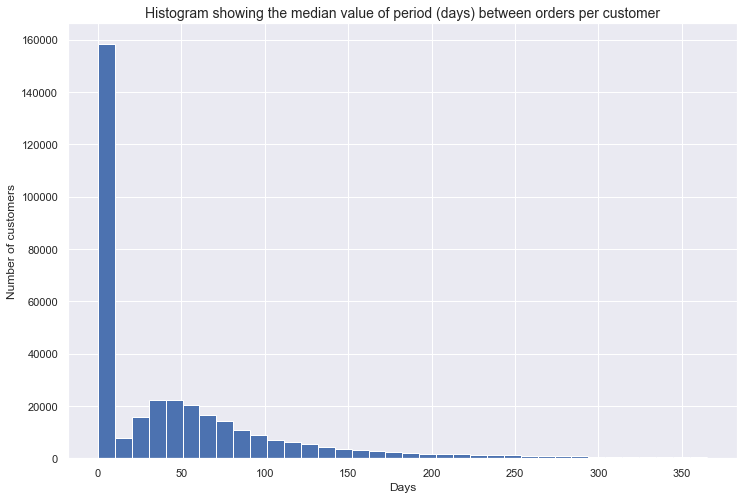

In [8]:
sns.set()
plt.figure(figsize=(12, 8))
cus_attr['median_timedelta'].hist(bins=36, range=(0, 365))
plt.xlabel('Days')
plt.ylabel('Number of customers')
plt.title('Histogram showing the median value of period (days) between orders per customer', fontsize=14)
plt.show()
# 42.5% of the customers only placed 1 order

In [53]:
timedelta_collection = [i for timelist in cus_attr['orders_timedeltas'].values for i in timelist]

In [27]:
len(timedelta_collection)

1179177

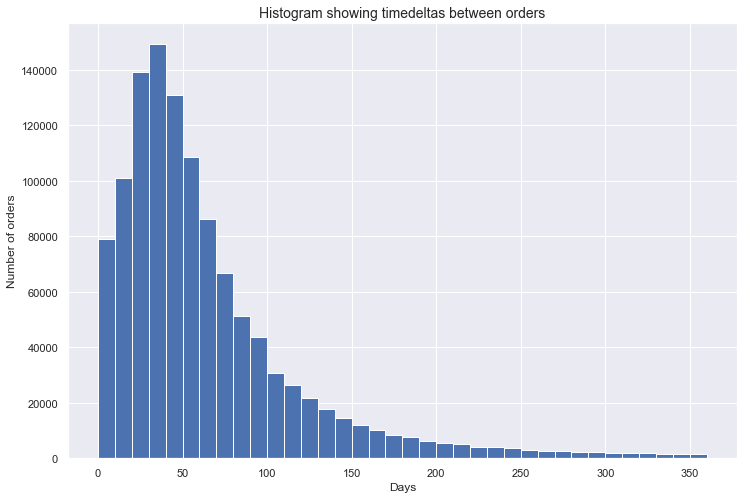

In [32]:
# Get probability distribution to weighted scoring
sns.set()
plt.figure(figsize=(12, 8))
plt.hist(timedelta_collection, bins=36, range=(0, 360))
plt.xlabel('Days')
plt.ylabel('Number of orders')
plt.title('Histogram showing timedeltas between orders', fontsize=14)
plt.show()

,sumsquare_error
invgamma,0.000007
betaprime,0.000011
invgauss,0.000013
fatiguelife,0.000014
exponnorm,0.000015


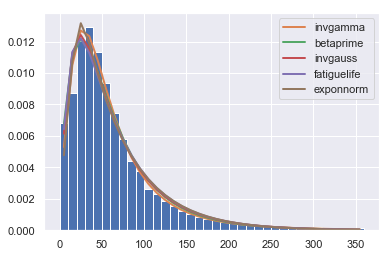

In [63]:
from fitter import Fitter
f = Fitter(timedelta_collection, xmin=None, xmax=360, bins=36, verbose=False, timeout=60) # distributions=['gamma', 'rayleigh', 'uniform'] as parameter
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f.summary()

In [70]:
f.fitted_param['invgamma']

(3.980326930596777, -26.804714883552595, 272.34272900209584)

In [84]:
f.fitted_pdf['invgamma']

array([5.28890349e-03, 1.05101581e-02, 1.27017490e-02, 1.23458326e-02,
       1.08059342e-02, 8.97444101e-03, 7.26191040e-03, 5.80725922e-03,
       4.62619727e-03, 3.68796992e-03, 2.94984849e-03, 2.37086948e-03,
       1.91629077e-03, 1.55822419e-03, 1.27488279e-03, 1.04947046e-03,
       8.69111388e-04, 7.23946429e-04, 6.06414539e-04, 5.10698299e-04,
       4.32302670e-04, 3.67737366e-04, 3.14278008e-04, 2.69786495e-04,
       2.32575620e-04, 2.01306699e-04, 1.74911854e-04, 1.52534729e-04,
       1.33485066e-04, 1.17203710e-04, 1.03235518e-04, 9.12082825e-05,
       8.08162447e-05, 7.18071395e-05, 6.39719644e-05, 5.71368603e-05])

In [92]:
f.y

array([0.00682751, 0.00873341, 0.01204054, 0.01289485, 0.01132598,
       0.00937231, 0.00744309, 0.0057805 , 0.00441875, 0.00379107,
       0.00264802, 0.0022824 , 0.00186522, 0.00152275, 0.00124731,
       0.00103561, 0.00086761, 0.00073123, 0.00066334, 0.00053776,
       0.00047021, 0.00044171, 0.00036277, 0.00035707, 0.00030671,
       0.00026974, 0.00024271, 0.00022794, 0.00020401, 0.00018657,
       0.00017905, 0.00015012, 0.00015038, 0.00014528, 0.0001344 ,
       0.00014208])

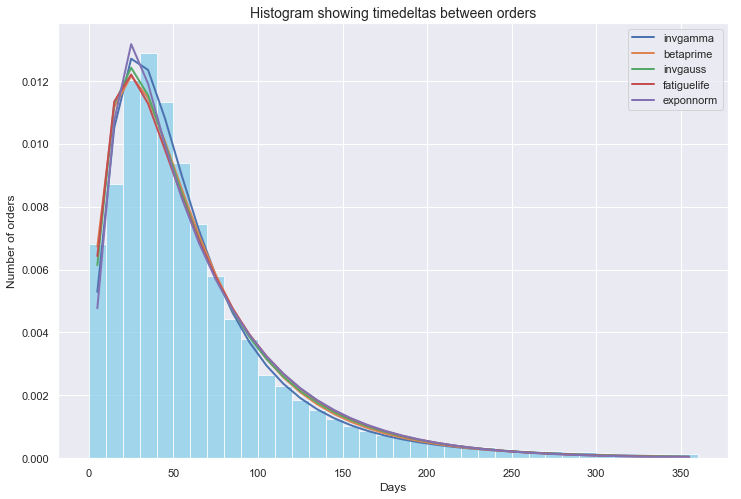

In [80]:
plt.figure(figsize=(12, 8))
f.plot_pdf()
plt.hist(timedelta_collection, bins=36, range=(0, 360), normed=True, color='skyblue', alpha=0.75)
plt.xlabel('Days')
plt.ylabel('Number of orders')
plt.title('Histogram showing timedeltas between orders', fontsize=14)
plt.show()

In [95]:
f.__dict__

##### Weighted sales value as a function of time

Gamma distribution is well known for being very flexible. We use this link to find the 
parameters of a gamma dist that suits our needs providing us a non-linear function for weight orders 
depending on how far from now are they. The closer ones obtains greater weights compared to the older. 

http://www.distributome.org/V3/calc/GammaCalculator.html

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
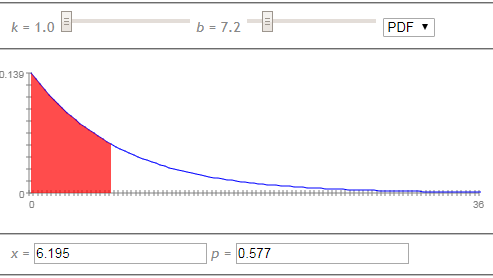

Considering x-axis values as a 10 days slot we got at the last position (36) the days completing almost a year where we assign a probability really close to 0.

In [96]:
from scipy.stats import gamma

In [98]:
shape = 1.0
scale = 7.2
loc = 0

In [109]:
rv = gamma(shape, loc = loc, scale = scale)

In [120]:
 x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)

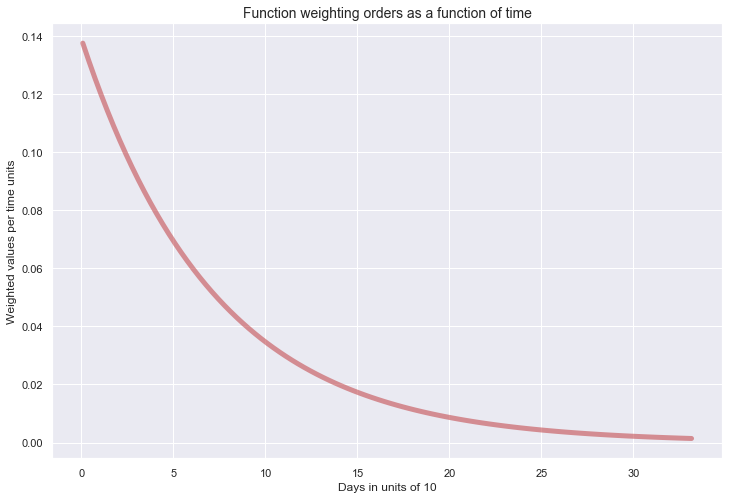

In [130]:
plt.figure(figsize=(12, 8))
plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='gamma pdf')
plt.xlabel('Days in units of 10')
plt.ylabel('Weighted values per time units')
plt.title('Function weighting orders as a function of time', fontsize=14)
plt.show()

In [16]:
# Weighted avgs assigned to orders having 30-60-90-180-270-360 days from now
# np.round([rv.pdf(3), rv.pdf(6), rv.pdf(9), rv.pdf(18), rv.pdf(27), rv.pdf(36)], 3) 

##### Orders - Purchasing Frequency

##### Survivals

##### Product Groups: PG2, PG3, PG4 - include article shops in the next future - 

In [10]:
main_pg_4_es = list(cus_attr[cus_attr['main_pg4_%_ord'] >= 0.50]['main_pg4'].value_counts().head(30).index.values)

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
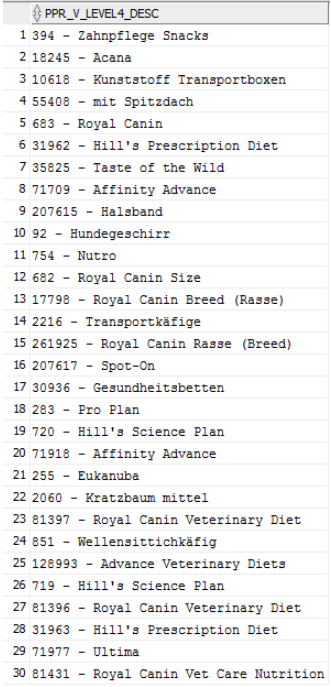

In [11]:
#basket avg, total net sales, orders, mean_timedelta avg, median_timedelta avg of the main PG4
cus_attr.groupby('main_pg4').agg({'basket_net_avg': np.mean,
                                  'total_net_sales': np.sum,
                                  'orders': np.sum,
                                  'mean_timedelta': np.mean,
                                  'median_timedelta': np.mean
                                 }).loc[main_pg_4_es].sort_values(by='median_timedelta').round(2)

,basket_net_avg,total_net_sales,orders,mean_timedelta,median_timedelta
main_pg4,,,,,
55408,64.69,329110.47,5179,29.89,29.13
92,33.89,157464.47,4424,33.55,32.12
10618,66.04,303171.79,4648,36.21,34.44
851,56.41,218511.12,3922,36.31,35.34
2216,49.38,272945.07,5449,41.08,39.23
30936,55.15,330477.00,6003,52.76,51.30
2060,49.77,360166.06,7364,56.92,55.73
207615,44.89,532061.50,11475,58.65,57.72
719,58.90,2310542.18,37797,65.04,59.37


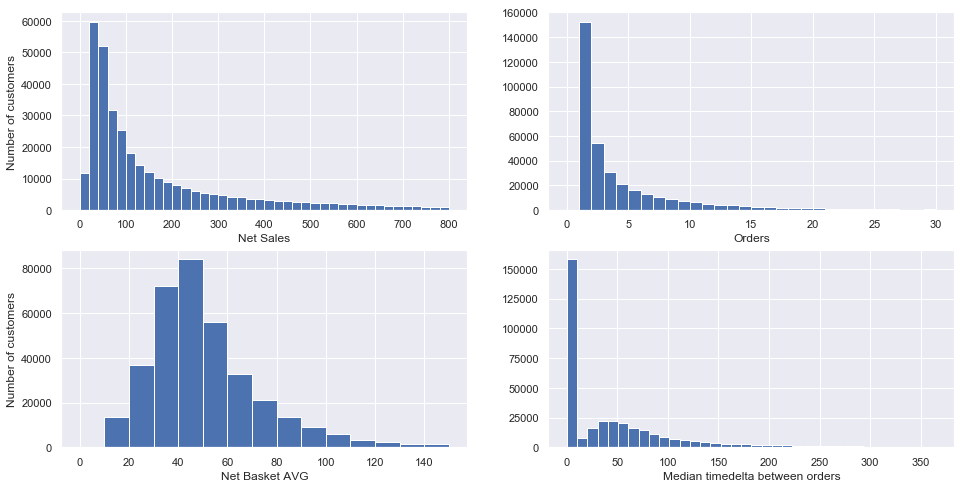

In [65]:
sns.set()
plt.figure(figsize=(16, 8))

plt.subplot(221)
cus_attr['total_net_sales'].hist(bins=40, range=(0, 800)) #Each bin has a range of 20€
plt.xlabel('Net Sales')
plt.ylabel('Number of customers')

plt.subplot(222)
cus_attr['orders'].hist(bins=30, range=(0, 30))
plt.xlabel('Orders')

plt.subplot(223)
cus_attr['basket_net_avg'].hist(bins=15, range=(0, 150))
plt.xlabel('Net Basket AVG')
plt.ylabel('Number of customers')

plt.subplot(224)
cus_attr['median_timedelta'].hist(bins=36, range=(0, 365))
plt.xlabel('Median timedelta between orders')

plt.show()

##### Web, web mobile, APP customers

##### NL Subscribers